<a href="https://colab.research.google.com/github/Eben2020-hp/Disease-Named-Entity-Extraction/blob/main/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1 align= 'center'> Disease Named Entity Extraction </h1>
<h2 align= 'center'> In Clinical Documents Using SpaCy </h2>


## **Introduction**

<p>
Named Entity Extraction (NER) is a sub-task of Information Extraction, which deals with finding and classifying named entities (a real-world object, such as a person, location, organization, product, etc., that can be denoted with a proper name) that are mentioned in an unstructured text into pre-defined categories such as person names, organizations, medical codes, etc. 
</p>

<img src="https://miro.medium.com/max/1400/1*0BuSAIQOLNQGVWJIxZhFuA.png" width= 1250 height= 450>

### **Named Entity Recognition Packages**

<p>
NER can be implemented with either statistical or rule-based methods, both of which require a large amount of labeled training data and are typically trained in a fully or semi-supervised manner. Statistical approaches to NER include Hidden Markov Models, Maximum Entropy, and Conditional Random Fields, as well as deep learning approaches with Recurrent Neural Networks, such as Seq2Seq. All of these processes involve sentence inputs and annotated sentence outputs. Many of these processes also involve additional feature engineering, providing as input summary statistics of the sentences.
</p>

### **Named Entity Recognition Evaluation Metrics**

<p>
NER is most commonly evaluated with Precision, Recall, and F1-score. F1-score can either be relaxed or strict, with the latter requiring the character offsets to match exactly.
</p>

### **Named Entity Recognition with SpaCy**

<p>
SpaCy is an open-source python library for NLP written in Python and Cython. It offers pre-trained models for multi-language NER, as well as allowing developers to train and deploy custom NER models on domain specific corpuses. SpaCy models are designed to be production-ready.
</p>

**_SpaCy's pretrained models are trained on the OntoNotes 5 corpus, and support the identification of the following entities:_**

<table>
<thead>
<tr><th>TYPE</th><th>DESCRIPTION</th></tr>
</thead>
<tbody>
<tr><td>PERSON</td><td>People, including fictional</td></tr>
<tr><td>NORP</td><td>Nationalities or religious or political groups</td></tr>
<tr><td>FAC</td><td>Buildings, airports, highways, bridges, etc</td></tr>
<tr><td>ORG</td><td>Companies, agencies, institutions, etc</td></tr>
<tr><td>GPE</td><td>Countries, cities, states</td></tr>
<tr><td>LOC</td><td>Non-GPE locations, mountain ranges, bodies of water</td></tr>
<tr><td>PRODUCT</td><td>Objects, vehicles, foods, etc. (Not services.)</td></tr>
<tr><td>EVENT</td><td>Named hurricanes, battles, wars, sports events, etc</td></tr>
<tr><td>WORK_OF_ART</td><td>Titles of books, songs, etc</td></tr>
<tr><td>LAW</td><td>Named documents made into laws</td></tr>
<tr><td>LANGUAGE</td><td>Any named language</td></tr>
<tr><td>DATE</td><td>Absolute or relative dates or periods</td></tr>
<tr><td>TIME</td><td>Times smaller than a day</td></tr>
<tr><td>PERCENT</td><td>Percentage, including ”%“</td></tr>
<tr><td>MONEY</td><td>Monetary values, including unit</td></tr>
<tr><td>QUANTITY</td><td>Measurements, as of weight or distance</td></tr>
<tr><td>ORDINAL</td><td>“first”, “second”, etc</td></tr>
<tr><td>CARDINAL</td><td>Numerals that do not fall under another type</td></tr>
</tbody>
</table>


## **Task at Hand**


<p>
This Jupyter notebook demonstrates Training and Serving Custom Named Entity Recognition (NER) models, which are used to identify named entities such as disease names from clinical narratives/documents in order to support clinical and translational research. NER is used in a number of business applications such as powering recommender systems, simplifying customer support, and optimizing internal search engines.
</p>

Here I will be creating a Clinical Named Entity Recognition model which can recognize the Disease Names from Clinical Text.

For this I have extracted annotated clinical text from the following github repo: https://github.com/dmis-lab/biobert.

- They provide annotated clinical text here: Named Entity Recognition: (17.3 MB), 8 datasets on Biomedical Named Entity Recognition (https://drive.google.com/open?id=1OletxmPYNkz2ltOr9pyT0b0iBtUWxslh).

- Once we download and unzip the files we get 8 Datasets with each dataset having the following files: 

   - train.tsv
   - test.tsv
   - dev.tsv
   - devel.tsv 

**In these .tsv files each word is annotated using the BIO format.**

| Annotations | Entity Type |
| --- | --- |
| B | Begin Entity |
| I | Inside Entity |
| O | Outside Entity |


***This notebook has been inpsired from :***
- https://aihub.cloud.google.com/p/products%2F2290fc65-0041-4c87-a898-0289f59aa8ba
- https://youtu.be/DxLcMI-EMYI

## **1. Import relevant Dependencies**

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [ ]:
# Python Imports
import math, time, random, datetime, sys

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Named Entity Recognition Packages
import spacy
from spacy.util import minibatch, compounding
from spacy import displacy
from itertools import chain

#### Convert the .tsv file to the format that is accepted by SpaCy for Training. 

At present our .tsv files are in **BIO Format**. We will convert them to an array like structure. This array format will have Sentences and within each Sentence we will have the Entities also present.
- *Example*: TRAIN_DATA = [(Sentence, {entities: [(start, end, label)]}, ...]

The ***load_data*** function parses and transforms the input data into the required format for SpaCy.

In [ ]:
def load_data_spacy(file_path):
    ''' 
        Converts data from:
        label \t word \n label \t word \n \n label \t word
        to: sentence, {entities : [(start, end, label), (stard, end, label)]}
    '''

    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split("\t")
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            if(label != 'O'):
                label = line[1]+ "_Disease"     # the .txt is formatted: label \t word, label[0:2] = label_type
            #label_type = line[0][0] # beginning of annotations - "B", intermediate - "I"
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space
           
            if label == 'I_Disease' :  # if at the end of an annotation
                entities.append(( start,end-1, label))  # append the annotation
                              
            if label == 'B_Disease':                         # if beginning new annotation
                entities.append(( start,end-1, label))# start annotation at beginning of word

           
            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)
 
        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels

#### Let us convert our Train, Test and Validation data to SpaCy Format.

In [ ]:
TRAIN_DATA, LABELS = load_data_spacy("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/train.tsv")   ## ("Datasets/BC5CDR-disease/train.tsv")
TEST_DATA, _ = load_data_spacy("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/test.tsv")
VALID_DATA, _ = load_data_spacy("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/train_dev.tsv")

### **Data overview**

Sample sentences from the training data, which contains information about Patients Medical condition.

In [ ]:
## Viewing the First 10 Sentences.
TRAIN_DATA[0:10]

[["Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .",
  {'entities': [(21, 29, 'B_Disease'),
    (30, 41, 'I_Disease'),
    (45, 54, 'B_Disease'),
    (55, 56, 'I_Disease'),
    (57, 58, 'I_Disease'),
    (59, 66, 'I_Disease')]}],
 ["OBJECTIVES : The United Kingdom Parkinson ' s Disease Research Group ( UKPDRG ) trial found an increased mortality in patients with Parkinson ' s disease ( PD ) randomized to receive 10 mg selegiline per day and L - dopa compared with those taking L - dopa alone .",
  {'entities': [(32, 41, 'B_Disease'),
    (42, 43, 'I_Disease'),
    (44, 45, 'I_Disease'),
    (46, 53, 'I_Disease'),
    (132, 141, 'B_Disease'),
    (142, 143, 'I_Disease'),
    (144, 145, 'I_Disease'),
    (146, 153, 'I_Disease'),
    (156, 158, 'B_Disease')]}],
 ['Recently , we found that therapy with selegiline and L - dopa was associated with selective systolic orthostatic hypotension which was abolished by wit

In [ ]:
## Sample labeled Annotations for the Training data
[x[1] for x in TRAIN_DATA[1:10]]

[{'entities': [(32, 41, 'B_Disease'),
   (42, 43, 'I_Disease'),
   (44, 45, 'I_Disease'),
   (46, 53, 'I_Disease'),
   (132, 141, 'B_Disease'),
   (142, 143, 'I_Disease'),
   (144, 145, 'I_Disease'),
   (146, 153, 'I_Disease'),
   (156, 158, 'B_Disease')]},
 {'entities': [(92, 100, 'B_Disease'),
   (101, 112, 'I_Disease'),
   (113, 124, 'I_Disease')]},
 {'entities': [(274, 285, 'B_Disease'), (286, 297, 'I_Disease')]},
 {'entities': [(97, 99, 'B_Disease')]},
 {'entities': [(32, 40, 'B_Disease'),
   (41, 52, 'I_Disease'),
   (53, 64, 'I_Disease'),
   (95, 97, 'B_Disease')]},
 {'entities': [(19, 30, 'B_Disease'), (31, 42, 'I_Disease')]},
 {'entities': [(0, 11, 'B_Disease'), (12, 23, 'I_Disease')]},
 {'entities': [(39, 46, 'B_Disease'),
   (47, 50, 'I_Disease'),
   (51, 57, 'I_Disease'),
   (58, 66, 'I_Disease'),
   (67, 70, 'I_Disease'),
   (71, 80, 'I_Disease'),
   (81, 86, 'I_Disease'),
   (87, 96, 'I_Disease')]},
 {'entities': [(128, 139, 'B_Disease'), (140, 151, 'I_Disease')]}]

In [ ]:
print(f"TRAIN Data has {len(TRAIN_DATA)} Sentences with Entities present")
print(f"TEST Data has {len(TEST_DATA)} Sentences with Entities present")
print(f"VALID Data has {len(VALID_DATA)} Sentences with Entities present")

TRAIN Data has 2658 Sentences with Entities present
TEST Data has 2842 Sentences with Entities present
VALID Data has 5385 Sentences with Entities present


#### Here I have removed all Sentences which Don't have Entites in them. Thus we have only Sentences with Entities.

### Evaluation Metrics
Model Performance is assessed on the entirety of the Test Dataset  based on the following Metrics and their Definitions.

> #### TP = ***Word predicted as either I_Disease or B_Disease and present in the data(train/test/validation) as as either I_Disease or B_Disease.***

> #### FP = ***Word predicted as either I_Disease or B_Disease and not present in the data (train/test/validation) as as either I_Disease or B_Disease.*** 

> #### FN = ***Word present in the data(train/test/validation) data as as either I_Disease or B_Disease but not predicted as as either I_Disease or B_Disease.***

### ***Metrics:*** 
- **Precision** = True Positives / (True Positives + False Positives) 
- **Recall** = True Positives / (True Positives + False Negatives) 
- **F1-score** = 2*((Precision*Recall)/(Precision + Recall)) *[Harmonic Average of Precision and Recall]*

In [ ]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

#### Let us define a method to evaluate our Named Entity Recognition Model.

In [ ]:
# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f": np.mean(f1s)}

Now let us train a custom named entity recognition model in spaCy for detecting Disease entities We use an existing model "en_core_web_md"( English medium sized model). This is a CNN model. This model by deafult has POS tagger, Dependency parser and Named entity recognition functionalities We only re-train the named entity recognition part of the model.

Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. ... The term dropout refers to randomly "dropping out", or omitting, units (both hidden and visible) during the training process of a neural network. In our case if dropout = 0.5 there is a 50% dropping out otmitting units during training process of our model

In [ ]:
def train_spacy(train_data, labels, iterations, dropout = 0.5, display_freq = 1):
    ''' Train a spacy NER model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    train_f1scores=[]
    valid_f1scores=[]
    test_f1scores=[]

    nlp = spacy.load("en_core_web_md")
    #nlp = spacy.blank('en')

    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe("ner")
   
    # Add Entity Labels to the NER Pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other Pipelines in SpaCy to only Train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):

        optimizer = nlp.begin_training()
        for itr in range(iterations):

            random.shuffle(train_data) # shuffle the Training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(16.0, 64.0, 1.5))

            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(          
                    texts,
                    annotations,
                    drop = dropout,  
                    sgd = optimizer,
                    losses = losses)

            scores = evaluate(nlp,TRAIN_DATA)
            train_f1scores.append(scores["textcat_f"])
            print('=======================================')
            print('Interation = '+str(itr))
            print('Losses = '+str(losses))
            
            print('===============TRAIN DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))

            scores = evaluate(nlp,VALID_DATA)
            valid_f1scores.append(scores["textcat_f"])
            print('===============VALID DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))

            scores = evaluate(nlp,TEST_DATA)
            test_f1scores.append(scores["textcat_f"])
            print('===============TEST DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            print('=======================================')
            print()
            
    return nlp, train_f1scores, valid_f1scores, test_f1scores

In [ ]:
## !python3 -m spacy download en_core_web_md

#### Lets train the model on our dataset

In [ ]:
# Train (and save) the NER model
ner, train_f1scores, valid_f1scores, test_f1scores = train_spacy(TRAIN_DATA, LABELS, 20)
ner.to_disk("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/spacy_example")

Interation = 0
Losses = {'ner': 53083.19427680969}
===============TRAIN DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0

Interation = 1
Losses = {'ner': 47111.194595336914}
===============TRAIN DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0

Interation = 2
Losses = {'ner': 47224.17700386047}
===============TRAIN DATA========================
F1-score = 0.006186257935693601
Precision = 0.005289064459493353
Recall = 0.008276899924755455
===============VALID DATA========================
F1-score = 0.007482317538027844
Precision = 0.006383914754388291
Recall = 0.01002785515

### Visualize Model Performance

Text(0.5, 1.0, 'F1 score vs Iterations for Train and Test data')

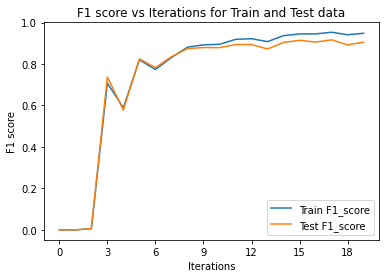

In [ ]:
x=range(0,20)
ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(train_f1scores,label="Train F1_score")
ax.plot(test_f1scores,label="Test F1_score")
ax.set_xlabel('Iterations')
ax.set_ylabel('F1 score')
ax.legend()
ax.set_title('F1 score vs Iterations for Train and Test data')

Text(0.5, 1.0, 'F1 score vs Iterations for validation and test data')

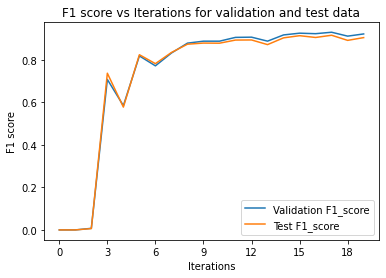

In [ ]:
x=range(0,20)
ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1scores,label="Validation F1_score")
ax.plot(test_f1scores,label="Test F1_score")
ax.set_xlabel('Iterations')
ax.set_ylabel('F1 score')
ax.legend()
ax.set_title('F1 score vs Iterations for validation and test data')

### Test model on new sentences

To test the model on new sentences, the load_model function is used to reload the trained model weights, and load_data is called to load and transform the test data. 

The spacy function displacy is used to visualize the predictions of the first 20 Test Sentences. 
- As the results show, the architecture has learned good representations of the entities. However, there still exist a few errors. While some of these may be mitigated with increased training time (the loss was still decreasing rapidly after 5 iterations), others may require additional pre-processing, such as fixing spelling mistakes.



#### Load the Saved Model

In [ ]:
from spacy import displacy

def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
   
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

#### Lets test our model on Test data

In [ ]:
ner = load_model("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/spacy_example")


test_sentences = [x[0] for x in TEST_DATA[0:15]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = ner(x)
    displacy.render(doc, jupyter = True, style = "ent")

- From the above output we can see that the Model works perfectly well with regard to Test Data.

### Results on Unseen Text 

In [ ]:
ner = load_model("/content/drive/MyDrive/NLP Case Study/Datasets/BC5CDR-disease/spacy_example")

doc = ner('''Identification of APC2,	a homologue of the adenomatous polyposis coli	tumour suppressor. The adenomatous polyposis coli ( APC ) tumour - suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta (GSK - 3beta ), axin/conductin and betacatenin. Complex formation induces the rapid degradation of betacatenin. 
In colon carcinoma cells, loss of APC leads to the accumulation of betacatenin in the nucleus, where it binds to and activates the Tcf - 4 transcription factor (reviewed in [1][2]).Here, we report the identification and genomic structure of APC homologues. Mammalian APC2, which closely resembles APC in overall domain structure , was functionally analyzed and shown to contain two SAMP domains, both of which are required for binding to conductin .
Like APC,	APC2 regulates the formation of active betacatenin - Tcf complexes, as demonstrated using transient transcriptional activation assays in APC - /	- colon carcinoma cells. Human APC2 maps to chromosome 19p13.3. APC and APC2 may therefore have comparable functions in development and cancer. A common MSH2 mutation in English and North American HNPCC families: origin, phenotypic expression, and sex specific differences in colorectal cancer.''')

displacy.render(doc, jupyter=True, style = "ent")

#### Conclusion

- Here we can see that when trying to Recognize on unseen data **Cancer** and **Colorectal Cancer** Have been correctly identified. But **Tumour** Is not correctly Identified and **Adenomatous Polyposis Coli** has not even been identified. 

Hence we can see that our Custom Model does need a few more modifications but this can be improved by training with more data. 